<a href="https://colab.research.google.com/github/daihoc24/ProjectML/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive'

Mounted at /content/gdrive
/content/gdrive/MyDrive


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64


<Axes: >

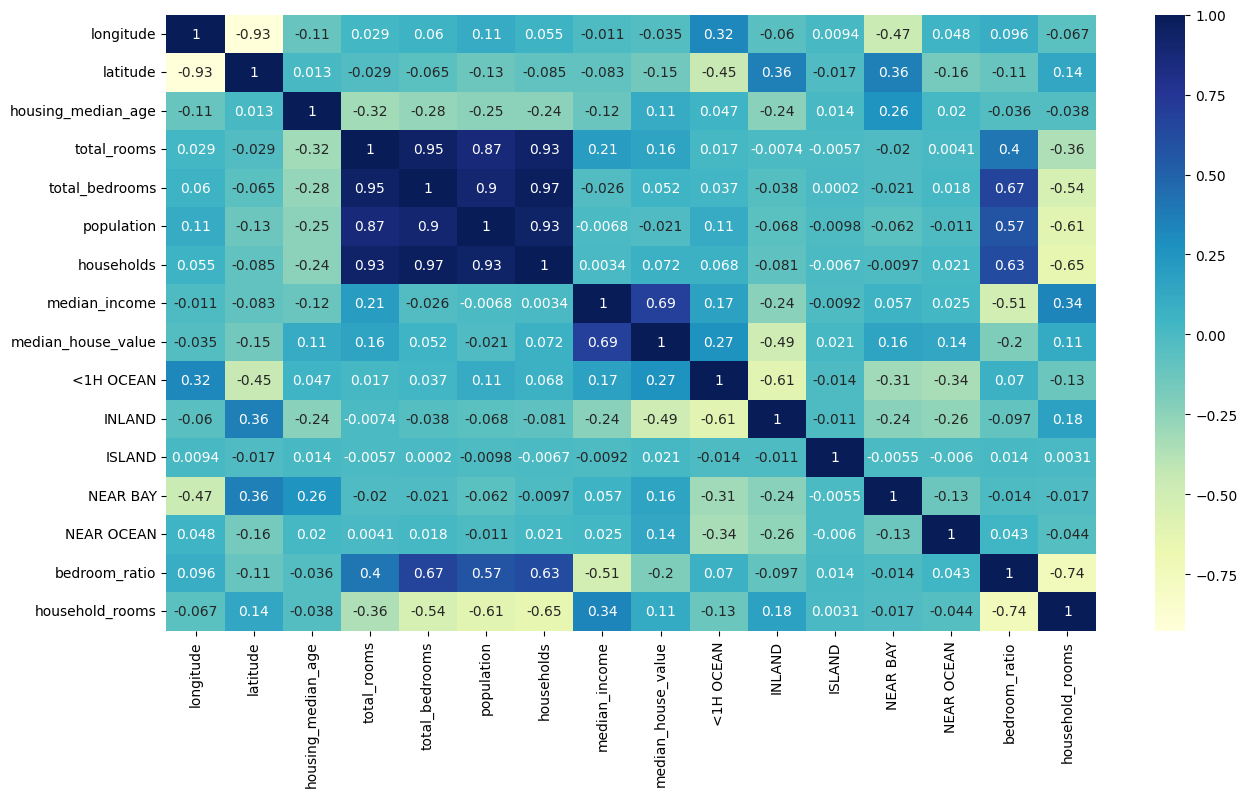

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error, r2_score

data = pd.read_csv('housing.csv')
data.info()
# Loại bỏ các hàng có giá trị thiếu
data.dropna(inplace = True)
data.info()

X = data.drop('median_house_value', axis=1)
y = data['median_house_value']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Chuyển đổi các biến phân loại thành các biến giả trong dữ liệu huấn luyện
train_data = X_train.join(y_train)
train_data = train_data.join(pd.get_dummies(train_data.ocean_proximity, dtype=int)).drop(['ocean_proximity'], axis=1)
# Chuyển đổi các biến phân loại thành các biến giả trong dữ liệu kiểm tra
test_data = X_test.join(y_test)
test_data = test_data.join(pd.get_dummies(test_data.ocean_proximity, dtype=int)).drop(['ocean_proximity'], axis=1)


# Biến đổi log các đặc trưng trong dữ liệu huấn luyện
train_data['total_rooms'] = np.log(train_data['total_rooms'] + 1)
train_data['total_bedrooms'] = np.log(train_data['total_bedrooms'] + 1)
train_data['population'] = np.log(train_data['population'] + 1)
train_data['households'] = np.log(train_data['households'] + 1)
# Tạo đặc trưng mới trong dữ liệu huấn luyện
train_data['bedroom_ratio'] = train_data['total_bedrooms'] / train_data['total_rooms']
train_data['household_rooms'] = train_data['total_rooms'] / train_data['households']


# Biến đổi log các đặc trưng trong dữ liệu kiểm tra
test_data['total_rooms'] = np.log(test_data['total_rooms'] + 1)
test_data['total_bedrooms'] = np.log(test_data['total_bedrooms'] + 1)
test_data['population'] = np.log(test_data['population'] + 1)
test_data['households'] = np.log(test_data['households'] + 1)
# Tạo đặc trưng mới trong dữ liệu kiểm tra
test_data['bedroom_ratio'] = test_data['total_bedrooms'] / test_data['total_rooms']
test_data['household_rooms'] = test_data['total_rooms'] / test_data['households']

# Chuẩn hóa dữ liệu huấn luyện
scaler = StandardScaler()
X_train_s = scaler.fit_transform(train_data.drop(['median_house_value'], axis=1))
y_train = train_data['median_house_value']

# Chuẩn hóa dữ liệu kiểm tra
X_test_s = scaler.transform(test_data.drop(['median_house_value'], axis=1))
y_test = test_data['median_house_value']

# train_data.hist(figsize=(15,12))
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(), annot=True, cmap="YlGnBu")

LinearRegression

In [5]:
from sklearn.metrics import mean_squared_error, r2_score

reg = LinearRegression()
reg.fit(X_train_s, y_train)
y_pred_reg = reg.predict(X_test_s)
r2_reg = r2_score(y_test, y_pred_reg)
mape_reg = mean_absolute_percentage_error(y_test, y_pred_reg)
accuracy_reg = (1 - mape_reg) * 100
accuracy_reg

72.06899483164652

RandomForestRegressor

In [6]:
forest = RandomForestRegressor()
forest.fit(X_train_s, y_train)
y_pred_forest = forest.predict(X_test_s)
r2_forest = r2_score(y_test, y_pred_forest)
mape_forest = mean_absolute_percentage_error(y_test, y_pred_forest)
accuracy_forest = (1 - mape_forest) * 100
accuracy_forest

81.72348682055001

In [9]:
forest = RandomForestRegressor()
param_grid = {
    "n_estimators" : [100, 200, 300],
    "min_samples_split" : [2, 4],
    "max_depth" : [None, 4, 8]
}
grid_search = GridSearchCV(forest, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True)
grid_search.fit(X_train_s, y_train)
best_forest = grid_search.best_estimator_
y_pred_best_forest = best_forest.predict(X_test_s)
r2_best_forest = r2_score(y_test, y_pred_best_forest)
mape_best_forest = mean_absolute_percentage_error(y_test, y_pred_best_forest)
accuracy_best_forest = (1 - mape_best_forest) * 100
accuracy_best_forest

81.72429484712511

Neural Network

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(64, input_dim=X_train_s.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error', metrics=['mean_squared_error'])
model.fit(X_train_s, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.2)

y_pred_nn = model.predict(X_test_s).flatten()
r2_nn = r2_score(y_test, y_pred_nn)
mape_nn = mean_absolute_percentage_error(y_test, y_pred_nn)
accuracy_nn = (1 - mape_nn) * 100
accuracy_nn

Epoch 1/100
409/409 [==============================] - 2s 3ms/step - loss: 55526940672.0000 - mean_squared_error: 55526940672.0000 - val_loss: 57212047360.0000 - val_mean_squared_error: 57212047360.0000
Epoch 2/100
409/409 [==============================] - 1s 2ms/step - loss: 53616451584.0000 - mean_squared_error: 53616451584.0000 - val_loss: 53309485056.0000 - val_mean_squared_error: 53309485056.0000
Epoch 3/100
409/409 [==============================] - 1s 2ms/step - loss: 47567683584.0000 - mean_squared_error: 47567683584.0000 - val_loss: 44768301056.0000 - val_mean_squared_error: 44768301056.0000
Epoch 4/100
409/409 [==============================] - 1s 2ms/step - loss: 37590118400.0000 - mean_squared_error: 37590118400.0000 - val_loss: 33163864064.0000 - val_mean_squared_error: 33163864064.0000
Epoch 5/100
409/409 [==============================] - 1s 2ms/step - loss: 26446434304.0000 - mean_squared_error: 26446434304.0000 - val_loss: 22364151808.0000 - val_mean_squared_error: 22

75.08403063191827

DecisionTree

In [11]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train_s, y_train)
y_pred_tree = tree_reg.predict(X_test_s)
r2_tree = r2_score(y_test, y_pred_tree)
mape_tree = mean_absolute_percentage_error(y_test, y_pred_tree)
accuracy_tree = (1 - mape_tree) * 100
accuracy_tree

75.83263544873675

In [12]:
# Báo cáo tổng kết
models = ['Linear Regression', 'Random Forest', 'Best Random Forest', 'Neural Network', 'Decision Tree']
accuracies = [accuracy_reg, accuracy_forest, accuracy_best_forest, accuracy_nn, accuracy_tree]

report = pd.DataFrame({'Model': models, 'Accuracy (%)': accuracies})
print(report)

                Model  Accuracy (%)
0   Linear Regression     72.068995
1       Random Forest     81.723487
2  Best Random Forest     81.724295
3      Neural Network     75.084031
4       Decision Tree     75.832635
